In [1]:
# les bibliotheques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

## Sommaire
1. Import
2. Préparation des données
3. Mise en place des features engineering
4. Préparation des données en vue de la modélisation
4. Baseline
5. Modèles linéaires
6. Modèles d’arbres
7. Méthodes d’ensemble
8. Choix du modèle
9. Analyse des features_importantes 
10. Analyse de la variable ENERGYSTARscore

In [2]:
print("\n2. CHARGEMENT et PREPARATION DES DONNÉES")
df_engineered = pd.read_csv("clean_seattle.csv")
print(f"Shape des données : {df_engineered.shape}")
df_engineered.columns



2. CHARGEMENT et PREPARATION DES DONNÉES
Shape des données : (669, 14)


Index(['PropertyGFATotal', 'PropertyGFABuilding(s)', 'NumberofFloors',
       'NumberofBuildings', 'YearBuilt', 'PrimaryPropertyType',
       'LargestPropertyUseTypeGFA', 'ZipCode', 'Neighborhood', 'Latitude',
       'Longitude', 'ENERGYSTARScore', 'log_TotalGHGEmissions',
       'log_SiteEnergyUse_kBtu'],
      dtype='object')


3. MISE EN PLACE DE FEATURES ENGINEERING  


Création de variables d'engineering

In [3]:
# 1. Fonction générique pour créer et nettoyer un ratio afin d'éviter les cas problématiques lors de division ou multiplication
def create_ratio_feature(df, numerator, denominator, new_col):
    """
    Crée df[new_col] = df[numerator] / df[denominator],
    en gérant :
    • colonnes manquantes → new_col = NaN  
    • dénominateur zéro → NaN  
    • infinis → NaN  
    • NaN → remplacés par la médiane de new_col
    """
    # 1) Division sécurisée (0 → NaN pour éviter div par zéro)
    if numerator not in df.columns or denominator not in df.columns:
        df[new_col] = np.nan
    else:
        df[new_col] = df[numerator] / df[denominator].replace(0, np.nan)

    # 2) Nettoyage des infinis
    df[new_col].replace([np.inf, -np.inf], np.nan, inplace=True)

    # 3) Remplacement des NaN par la médiane
    median = df[new_col].median(skipna=True)
    df[new_col].fillna(median, inplace=True)


# 2. Création de BuildingAge
df_engineered['BuildingAge'] = 2016 - df_engineered['YearBuilt']
df_engineered['BuildingAge'].fillna(df_engineered['BuildingAge'].median(), inplace=True)
# on mets la feature en BuildingAge en tranche d'années
bins  = [1900, 1950, 1970, 1990, 2010, 2025]
labels = ['<1950', '1950-1969', '1970-1989', '1990-2009', '>=2010']
df_engineered['YearBuilt_bin'] = pd.cut(
    df_engineered['YearBuilt'],
    bins=bins,
    labels=labels,
    right=False
)

# 3. Création des ratios : Surface totale / nombre d’étages
create_ratio_feature(
    df_engineered,
    numerator='PropertyGFATotal',
    denominator='NumberofFloors',
    new_col='AvgFloorArea'
)

# Surface brute moyenne par bâtiment
create_ratio_feature(
    df_engineered,
    numerator='PropertyGFATotal',
    denominator='NumberofBuildings',
    new_col='GFATotal_per_Building'
)

# Vérification 
print("Aperçu des nouvelles features dérivées :")
print(df_engineered[['BuildingAge', 'AvgFloorArea', 'GFATotal_per_Building']].head())


Aperçu des nouvelles features dérivées :
   BuildingAge  AvgFloorArea  GFATotal_per_Building
0           89   7369.500000                88434.0
1           47  23319.756098               956110.0
2           90   6132.000000                61320.0
3           17  48644.000000                97288.0
4           90   7546.181818                83008.0


Simplification de certaines variables catégorielles comme le voisinage et le type de bâtiments

In [4]:

# 1. Afficher les comptes pour voir quelles catégories sont rares
print("=== PrimaryPropertyType avant regroupement ===")
print(df_engineered['PrimaryPropertyType'].value_counts())

# 2. Regrouper les valeurs rares de PrimaryPropertyType (<10 occ.)
value_counts = df_engineered['PrimaryPropertyType'].value_counts()
to_other = value_counts[value_counts < 10].index
df_engineered['PrimaryPropertyType_grouped'] = (
    df_engineered['PrimaryPropertyType']
    .replace(to_other, 'Other')
)

print("\n=== PrimaryPropertyType après regroupement ===")
print(df_engineered['PrimaryPropertyType_grouped'].value_counts())

# 3. Afficher les comptes de Neighborhood avant regroupement
print("\n=== Neighborhood avant regroupement ===")
print(df_engineered['Neighborhood'].value_counts().head(20))  # top 20 pour lisibilité

# 4. Regrouper Neighborhood via fréquence cumulée (top 90 %)
freq = df_engineered['Neighborhood'].value_counts(normalize=True)
tops = freq[freq.cumsum() <= 0.90].index.tolist()
df_engineered['Neighborhood_grouped'] = (
    df_engineered['Neighborhood']
    .where(df_engineered['Neighborhood'].isin(tops), 'Other')
)

print("\n=== Neighborhood après regroupement ===")
print(df_engineered['Neighborhood_grouped'].value_counts().head(20))

=== PrimaryPropertyType avant regroupement ===
PrimaryPropertyType
Other                          121
Small- and Mid-Sized Office    111
Warehouse                       99
Retail Store                    49
Worship Facility                46
Hotel                           43
K-12 School                     35
Distribution Center             24
Self-Storage Facility           22
Supermarket / Grocery Store     21
Medical Office                  20
Large Office                    17
Residence Hall                  15
University                      14
Senior Care Community            9
Restaurant                       6
Refrigerated Warehouse           6
Hospital                         5
Laboratory                       5
Low-Rise Multifamily             1
Name: count, dtype: int64

=== PrimaryPropertyType après regroupement ===
PrimaryPropertyType_grouped
Other                          153
Small- and Mid-Sized Office    111
Warehouse                       99
Retail Store              

Analyse et Transformation Logarithmique de Variables Clés

--- Analyse AVANT transformation ---

Asymétrie (skewness) des variables initiales :
PropertyGFATotal             5.508632
LargestPropertyUseTypeGFA    5.826387
AvgFloorArea                 4.993834
dtype: float64

Distributions des variables initiales :


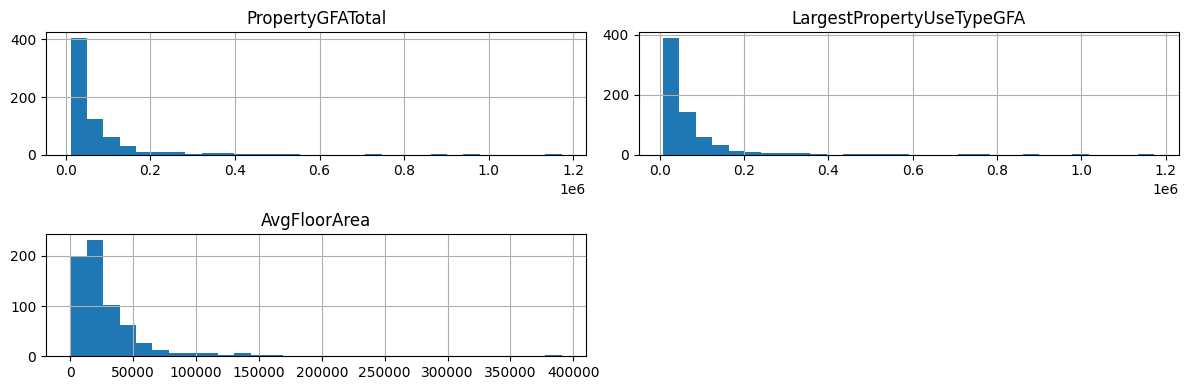


Application de la transformation log(1+x)...
Nouvelles colonnes 'log_...' créées.

--- Analyse APRÈS transformation ---

Distributions des variables transformées :


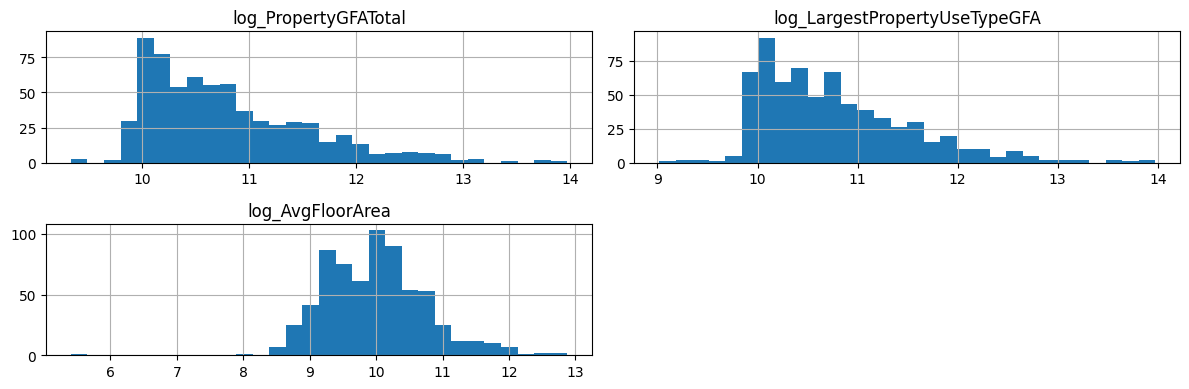

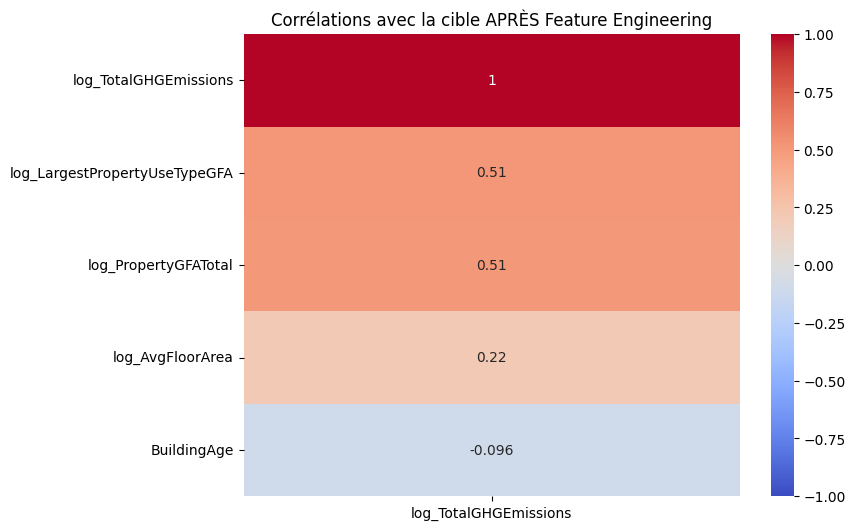

In [5]:
# 1. Définir les colonnes numériques à analyser
cols_to_transform = ['PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'AvgFloorArea']

# 2. Analyse AVANT transformation
print("--- Analyse AVANT transformation ---")
print("\nAsymétrie (skewness) des variables initiales :")
print(df_engineered[cols_to_transform].skew())

print("\nDistributions des variables initiales :")
df_engineered[cols_to_transform].hist(bins=30, figsize=(12, 4))
plt.tight_layout()
plt.show()

# 3. Appliquer la transformation logarithmique
print("\nApplication de la transformation log(1+x)...")
for col in cols_to_transform:
    df_engineered[f'log_{col}'] = np.log1p(df_engineered[col])
print("Nouvelles colonnes 'log_...' créées.")

# 4. Analyse APRÈS transformation
log_cols = [f'log_{col}' for col in cols_to_transform]
print("\n--- Analyse APRÈS transformation ---")
print("\nDistributions des variables transformées :")
df_engineered[log_cols].hist(bins=30, figsize=(12, 4))
plt.tight_layout()
plt.show()

# 5.  Vérifier la corrélation des nouvelles variables avec la cible

cols_for_corr = log_cols + ['BuildingAge', 'log_TotalGHGEmissions'] # On ajoute la cible et l'âge

corr_matrix = df_engineered[cols_for_corr].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix[['log_TotalGHGEmissions']].sort_values(by='log_TotalGHGEmissions', ascending=False),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)
plt.title("Corrélations avec la cible APRÈS Feature Engineering")
plt.show()


Sur cette heatmap, on voit que les 3 premières log sont bien corrélées.  
Quant à l'âge des buildings, cela est cohérent avec la logique métier puisque
les bâtiments les plus récents ont plutôt tendance  
à plus émettre ce qui semble contre-intuitif au premier abord mais qui s'explique par le fait  
qu'ils ont plus d'équipements modernes (exemple : climatisation) et des espaces plus grands.

MODELISATION  
4. Chargement et préparation des données

In [6]:
#sauvegarde du dataframe enrichi
df_engineered.to_csv('donnees_ameliorees.csv', index=False)


In [7]:
#DÉFINITION DES FEATURES ET DE LA CIBLE À PARTIR DU DATAFRAME AMÉLIORÉ

target = 'log_TotalGHGEmissions'

#  Variables numériques : on prend les versions LOG et les nouvelles features.
#  On évite les versions originales (ex: 'PropertyGFATotal') pour ne pas avoir de doublons.
numerical_features = [
    'log_PropertyGFATotal',
    'log_LargestPropertyUseTypeGFA',
    'log_AvgFloorArea',
    'BuildingAge',
    'NumberofFloors',
    'NumberofBuildings',
    'Latitude',
    'Longitude'
]

# Variables catégorielles : on prend les versions regroupées.
categorical_features = ['PrimaryPropertyType_grouped', 'Neighborhood_grouped' ]

# On s'assure que toutes les colonnes existent bien dans le DataFrame avant de continuer
all_features = numerical_features + categorical_features
missing = [c for c in all_features + [target] if c not in df_engineered.columns]
if missing:
    raise ValueError(f"Colonnes manquantes : {missing}")

# On crée notre X (features) et y(cible)
X = df_engineered[all_features]
y = df_engineered[target]

print("✓ Features sélectionnées pour le modèle (SANS ENERGYSTARScore) :")
print(f"  - Numériques ({len(numerical_features)})")
print(f"  - Catégorielles ({len(categorical_features)})")
print(f"✓ Target : {target}")


✓ Features sélectionnées pour le modèle (SANS ENERGYSTARScore) :
  - Numériques (8)
  - Catégorielles (2)
✓ Target : log_TotalGHGEmissions


Stratification et split des données

In [8]:
y_strat = pd.qcut(y, q=5, labels=False, duplicates='drop')

X_train, X_test, y_train, y_test, y_strat_train, y_strat_test = train_test_split(
    X, y, y_strat,
    test_size=0.20,
    random_state=42,
    stratify=y_strat
)

print(f"✓ Split réalisé : {len(X_train)} train, {len(X_test)} test")
print(f"Distribution stratification train : {np.bincount(y_strat_train)}")
print(f"Distribution stratification test : {np.bincount(y_strat_test)}")


✓ Split réalisé : 535 train, 134 test
Distribution stratification train : [107 107 107 107 107]
Distribution stratification test : [27 27 26 27 27]


Définition du préprocesseur

In [9]:
preproc = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
     categorical_features)
])

Mise en place de la validation croisée

In [10]:
# Configuration de la validation croisée - permet de diviser les données en plusieurs blocs, entraîner certain et tester sur d'autres
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Définir l'objet de validation croisée stratifiée à utiliser dans les GridSearchCV
#    Permet de respecter la proportion dans chaque pli et donc d'assurer un meilleur choix pour les hyperparamètres du modèle
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Liste des métriques 
scoring = {
    'MAE':  'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error', 
    'R2':   'r2'
}
# Fonction RMSE pour évaluations finales
def rmse(y_true, y_pred):
     return np.sqrt(mean_squared_error(y_true, y_pred))

# Dictionnaire pour stocker tous les résultats
results = {
    'model': [],
    'r2_cv_mean': [],
    'r2_cv_std': [],
    'rmse_cv_mean': [],
    'rmse_cv_std': [],
    'without_tuning_rmse': [],
    'with_tuning_rmse': [],
    'best_params': []
}


5. BASELINE

In [11]:
# Mise en place du modèle de base DummyRegressor - prédit juste la moyenne
print("1. MODÈLE BASELINE (DummyRegressor)")
print("-"*50)

dummy_pipe = Pipeline([
    ('prep', preproc),
    ('model', DummyRegressor(strategy='mean'))
])

# Cross-validation du baseline
cv_dummy = cross_validate(dummy_pipe, X_train, y_train, cv=cv, scoring=scoring)

baseline_r2 = cv_dummy['test_R2'].mean()
baseline_rmse = -cv_dummy['test_RMSE'].mean()
baseline_mae = -cv_dummy['test_MAE'].mean()

print(f"Baseline (DummyRegressor - moyenne) :")
print(f"  R2 CV    : {baseline_r2:.4f} ± {cv_dummy['test_R2'].std():.4f}")
print(f"  RMSE CV  : {baseline_rmse:.4f} ± {cv_dummy['test_RMSE'].std():.4f}")
print(f"  MAE CV   : {baseline_mae:.4f} ± {cv_dummy['test_MAE'].std():.4f}")
print(f" On note ici que nos modèles à entrainer doivent avoir des résultats inférieurs au niveau des RMSE et MAE à ces moyennes de base") 
print(f" pour le coefficient de détermination (R^2) l'objectif est d'avoir une valeur supérieure à -0.0119, l'idéal étant un score positif")

1. MODÈLE BASELINE (DummyRegressor)
--------------------------------------------------
Baseline (DummyRegressor - moyenne) :
  R2 CV    : -0.0119 ± 0.0150
  RMSE CV  : 1.4268 ± 0.0550
  MAE CV   : 1.1224 ± 0.0632
 On note ici que nos modèles à entrainer doivent avoir des résultats inférieurs au niveau des RMSE et MAE à ces moyennes de base
 pour le coefficient de détermination (R^2) l'objectif est d'avoir une valeur supérieure à -0.0119, l'idéal étant un score positif


6. Modèles linéaires : la régression linéaire simple 


In [12]:
print("\n2. RÉGRESSION LINÉAIRE SIMPLE")
print("-" * 50)

# La régression linéaire sert de baseline pour comprendre
# les relations linéaires dans nos données avant d'ajouter de la régularisation
linear_pipe = Pipeline([('prep', preproc), ('model', LinearRegression())])
cv_linear  = cross_validate(
    linear_pipe,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True   # ← on récupère train_X et test_XS
)
# très bon résultat et  point de départ, il explique 58% de la variance sur l'entraînement et 47% de la variance sur des données jamais vues, 
# l'écart train/test limité (~0.10) donc stable, bon signe car pas d'overfitting ici

print(f"  R^2 train CV : {cv_linear ['train_R2'].mean():.4f} ± {cv_linear ['train_R2'].std():.4f}")
print(f"  R^2  test  CV : {cv_linear ['test_R2'].mean():.4f} ± {cv_linear ['test_R2'].std():.4f}")
print(f"  RMSE train CV : {-cv_linear ['train_RMSE'].mean():.4f} ± {cv_linear ['train_RMSE'].std():.4f}")
print(f"  RMSE test  CV : {-cv_linear ['test_RMSE'].mean():.4f} ± {cv_linear ['test_RMSE'].std():.4f}")
print(f"  MAE train CV  : {-cv_linear ['train_MAE'].mean():.4f} ± {cv_linear ['train_MAE'].std():.4f}")
print(f"  MAE test  CV  : {-cv_linear ['test_MAE'].mean():.4f} ± {cv_linear ['test_MAE'].std():.4f}")
print(f"")


2. RÉGRESSION LINÉAIRE SIMPLE
--------------------------------------------------
  R^2 train CV : 0.5785 ± 0.0159
  R^2  test  CV : 0.4747 ± 0.1071
  RMSE train CV : 0.9247 ± 0.0242
  RMSE test  CV : 1.0239 ± 0.1167
  MAE train CV  : 0.7380 ± 0.0236
  MAE test  CV  : 0.8092 ± 0.0850



Regressions linéaires avancées : Lasso, Ridge et Elasticnet - Avec ou Sans Tuning  


In [13]:
models_and_grids = {
    'Ridge': {
        'estimator': Ridge(),
        'param_grid': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'Lasso': {
        'estimator': Lasso(max_iter=10_000),
        'param_grid': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'ElasticNet': {
        'estimator': ElasticNet(max_iter=10_000),
        'param_grid': {
            'model__alpha':    [0.01, 0.1, 1.0, 10.0, 100.0],
            'model__l1_ratio': [0.1, 0.5, 0.7, 0.9]
        }
    }
}

for name, cfg in models_and_grids.items():
    print(f"\n=== {name} ===")
    estimator  = cfg['estimator']
    param_grid = cfg['param_grid']

    # 2) Pipeline de base
    pipe = Pipeline([
        ('prep', preproc),
        ('model', estimator)
    ])

    # 3) Cross-validation sans tuning
    cv_res = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    print("  • Sans tuning :")
    print(f"    R² train CV : {cv_res['train_R2'].mean():.4f} ± {cv_res['train_R2'].std():.4f}")
    print(f"    R²  test CV : {cv_res['test_R2'].mean():.4f} ± {cv_res['test_R2'].std():.4f}")
    print(f"    RMSE train  : {-cv_res['train_RMSE'].mean():.4f} ± {cv_res['train_RMSE'].std():.4f}")
    print(f"    RMSE test   : {-cv_res['test_RMSE'].mean():.4f} ± {cv_res['test_RMSE'].std():.4f}")
    print(f"    MAE train   : {-cv_res['train_MAE'].mean():.4f} ± {cv_res['train_MAE'].std():.4f}")
    print(f"    MAE test    : {-cv_res['test_MAE'].mean():.4f} ± {cv_res['test_MAE'].std():.4f}")

    # 4) GridSearchCV avec tuning
    gs = GridSearchCV(
        pipe,
        {'model__' + k.split('__')[-1]: v for k, v in param_grid.items()},
        cv=cv,
        scoring=scoring,  # optimiser le RMSE
        refit='R2',
        return_train_score=True,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)

    best_idx    = gs.best_index_
    cv_results  = gs.cv_results_
    best_params = gs.best_params_

    print("  → Avec tuning (GridSearchCV) :")
    print(f"    Best params       : {best_params}")
    print(f"    R² train CV best  : {cv_results['mean_train_R2'][best_idx]:.4f}")
    print(f"    R²  test CV best  : {cv_results['mean_test_R2'][best_idx]:.4f}")
    print(f"    RMSE train best   : {-cv_results['mean_train_RMSE'][best_idx]:.4f}")
    print(f"    RMSE test best    : {-cv_results['mean_test_RMSE'][best_idx]:.4f}")
    print(f"    MAE train best    : {-cv_results['mean_train_MAE'][best_idx]:.4f}")
    print(f"    MAE test best     : {-cv_results['mean_test_MAE'][best_idx]:.4f}")

    # 5) Évaluation finale sur le jeu de test
    best_model = gs.best_estimator_
    y_pred     = best_model.predict(X_test)
    print("    Performance finale sur test set :")
    print(f"      R² test  : {r2_score(y_test, y_pred):.4f}")
    print(f"      RMSE test: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"      MAE test : {mean_absolute_error(y_test, y_pred):.4f}")

    # Les 3 modèles sont très proches, expliquant 47 à 48% de la variance sur le test final, on voit ici que le gridsearch a bien joué son rôle
    # le choix des hyperparamètres est crucial pour ces modèles linéaires régularisés - pas de surapprentissage à noter
    


=== Ridge ===


  • Sans tuning :
    R² train CV : 0.5780 ± 0.0159
    R²  test CV : 0.4772 ± 0.1097
    RMSE train  : 0.9252 ± 0.0242
    RMSE test   : 1.0211 ± 0.1187
    MAE train   : 0.7387 ± 0.0233
    MAE test    : 0.8059 ± 0.0867
  → Avec tuning (GridSearchCV) :
    Best params       : {'model__alpha': 1.0}
    R² train CV best  : 0.5780
    R²  test CV best  : 0.4772
    RMSE train best   : 0.9252
    RMSE test best    : 1.0211
    MAE train best    : 0.7387
    MAE test best     : 0.8059
    Performance finale sur test set :
      R² test  : 0.4724
      RMSE test: 1.0609
      MAE test : 0.8727

=== Lasso ===
  • Sans tuning :
    R² train CV : 0.0000 ± 0.0000
    R²  test CV : -0.0119 ± 0.0150
    RMSE train  : 1.4244 ± 0.0136
    RMSE test   : 1.4268 ± 0.0550
    MAE train   : 1.1209 ± 0.0148
    MAE test    : 1.1224 ± 0.0632
  → Avec tuning (GridSearchCV) :
    Best params       : {'model__alpha': 0.01}
    R² train CV best  : 0.5637
    R²  test CV best  : 0.4945
    RMSE train best   :

7. Modèles d'arbres de décision

In [14]:
print("4. MODÈLES NON-LINÉAIRES (Boosting et Random Forest)\n" + "-"*60)

# 1) Définir chaque modèle et sa grille de tuning
models_and_grids = {
    'GradientBoosting': {
        'estimator': GradientBoostingRegressor(random_state=42),
        'param_grid': {
            'model__n_estimators':  [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth':     [3, 5, 7]
        }
    },
    'RandomForest': {
        'estimator': RandomForestRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth':    [None, 5, 10]
        }
    }
}

for name, cfg in models_and_grids.items():
    print(f"\n=== {name} ===")
    estimator  = cfg['estimator']
    param_grid = cfg['param_grid']

    # Pipeline de base
    pipe = Pipeline([
        ('prep',  preproc),
        ('model', estimator)
    ])

    # 2) Sans tuning : cross-validation brute
    cv_res = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    print("  • Sans tuning :")
    print(f"    R² train CV : {cv_res['train_R2'].mean():.4f} ± {cv_res['train_R2'].std():.4f}")
    print(f"    R²  test CV : {cv_res['test_R2'].mean():.4f} ± {cv_res['test_R2'].std():.4f}")
    print(f"    RMSE train  : {-cv_res['train_RMSE'].mean():.4f} ± {cv_res['train_RMSE'].std():.4f}")
    print(f"    RMSE test   : {-cv_res['test_RMSE'].mean():.4f} ± {cv_res['test_RMSE'].std():.4f}")
    print(f"    MAE train   : {-cv_res['train_MAE'].mean():.4f} ± {cv_res['train_MAE'].std():.4f}")
    print(f"    MAE test    : {-cv_res['test_MAE'].mean():.4f} ± {cv_res['test_MAE'].std():.4f}")

    # 3) Avec tuning : GridSearchCV
    gs = GridSearchCV(
        pipe,
        param_grid,
        cv=cv,
        scoring=scoring, 
        refit='R2',
        return_train_score=True,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)

    best_idx   = gs.best_index_
    cv_results = gs.cv_results_
    best_params = gs.best_params_

    print("  → Avec tuning (GridSearchCV) :")
    print(f"    Best params       : {best_params}")
    print(f"    R² train CV best  : {cv_results['mean_train_R2'][best_idx]:.4f}")
    print(f"    R²  test CV best  : {cv_results['mean_test_R2'][best_idx]:.4f}")
    print(f"    RMSE train best   : {-cv_results['mean_train_RMSE'][best_idx]:.4f}")
    print(f"    RMSE test best    : {-cv_results['mean_test_RMSE'][best_idx]:.4f}")
    print(f"    MAE train best    : {-cv_results['mean_train_MAE'][best_idx]:.4f}")
    print(f"    MAE test best     : {-cv_results['mean_test_MAE'][best_idx]:.4f}")

    # 4) Évaluation finale sur le test set
    best_model = gs.best_estimator_
    y_pred     = best_model.predict(X_test)
    print("    Performance finale sur test set :")
    print(f"      R² test  : {r2_score(y_test, y_pred):.4f}")
    print(f"      RMSE test: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"      MAE test : {mean_absolute_error(y_test, y_pred):.4f}")

4. MODÈLES NON-LINÉAIRES (Boosting et Random Forest)
------------------------------------------------------------

=== GradientBoosting ===
  • Sans tuning :
    R² train CV : 0.8036 ± 0.0080
    R²  test CV : 0.4640 ± 0.0898
    RMSE train  : 0.6310 ± 0.0116
    RMSE test   : 1.0350 ± 0.0906
    MAE train   : 0.4971 ± 0.0122
    MAE test    : 0.8262 ± 0.0872
  → Avec tuning (GridSearchCV) :
    Best params       : {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 300}
    R² train CV best  : 0.6518
    R²  test CV best  : 0.4678
    RMSE train best   : 0.8403
    RMSE test best    : 1.0321
    MAE train best    : 0.6754
    MAE test best     : 0.8289
    Performance finale sur test set :
      R² test  : 0.4215
      RMSE test: 1.1109
      MAE test : 0.9139

=== RandomForest ===
  • Sans tuning :
    R² train CV : 0.9248 ± 0.0027
    R²  test CV : 0.4596 ± 0.0865
    RMSE train  : 0.3904 ± 0.0082
    RMSE test   : 1.0395 ± 0.0879
    MAE train   : 0.3105 ± 

8. Méthodes d'ensemble : Bagging / Boosting / Stacking

In [15]:
print("\n5. MÉTHODES D'ENSEMBLE")
print("-" * 50)

# Configuration des méthodes d'ensemble
ensemble_configs = {
    'Bagging': {
        'estimator': BaggingRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'model__n_estimators': [50, 100, 200],
            'model__max_samples':  [0.5, 0.8, 1.0],
            'model__max_features': [0.5, 0.8, 1.0]
        }
    },
    'HistGradientBoosting': {
        'estimator': HistGradientBoostingRegressor(random_state=42),
        'param_grid': {
            'model__max_iter':        [100, 200, 300],
            'model__learning_rate':   [0.05, 0.1, 0.2],
            'model__max_leaf_nodes':  [31, 63, 127]
        }
    }
}

# Test des modèles Bagging et HistGradientBoosting
for name, cfg in ensemble_configs.items():
    print(f"\n=== {name} ===")
    pipe       = Pipeline([('prep', preproc), ('model', cfg['estimator'])])
    param_grid = cfg['param_grid']

    # 1) Sans tuning
    cv_res = cross_validate(
        pipe, X_train, y_train,
        cv=cv, scoring=scoring,
        return_train_score=True, n_jobs=-1
    )
    print("  • Sans tuning :")
    print(f"    R² train CV : {cv_res['train_R2'].mean():.4f} ± {cv_res['train_R2'].std():.4f}")
    print(f"    R²  test CV : {cv_res['test_R2'].mean():.4f} ± {cv_res['test_R2'].std():.4f}")
    print(f"    RMSE train  : {-cv_res['train_RMSE'].mean():.4f} ± {cv_res['train_RMSE'].std():.4f}")
    print(f"    RMSE test   : {-cv_res['test_RMSE'].mean():.4f} ± {cv_res['test_RMSE'].std():.4f}")
    print(f"    MAE train   : {-cv_res['train_MAE'].mean():.4f} ± {cv_res['train_MAE'].std():.4f}")
    print(f"    MAE test    : {-cv_res['test_MAE'].mean():.4f} ± {cv_res['test_MAE'].std():.4f}")

    # 2) Avec tuning
    gs = GridSearchCV(
        pipe, param_grid, cv=cv, scoring=scoring,        
        refit='R2', return_train_score=True, n_jobs=-1
    )
    gs.fit(X_train, y_train)

    cvg         = gs.cv_results_
    best_idx    = gs.best_index_
    best_params = gs.best_params_

    print("  → Avec tuning (GridSearchCV) :")
    print(f"    Best params      : {best_params}")
    print(f"    R² train CV best : {cvg['mean_train_R2'][best_idx]:.4f}")
    print(f"    R²  test CV best : {cvg['mean_test_R2'][best_idx]:.4f}")
    print(f"    RMSE train best  : {-cvg['mean_train_RMSE'][best_idx]:.4f}")
    print(f"    RMSE test best   : {-cvg['mean_test_RMSE'][best_idx]:.4f}")
    print(f"    MAE train best   : {-cvg['mean_train_MAE'][best_idx]:.4f}")
    print(f"    MAE test best    : {-cvg['mean_test_MAE'][best_idx]:.4f}")

    # 3) Évaluation finale sur test set
    best_model = gs.best_estimator_
    y_pred     = best_model.predict(X_test)
    print("    Performance finale test set :")
    print(f"      R² test  : {r2_score(y_test, y_pred):.4f}")
    print(f"      RMSE test: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"      MAE test : {mean_absolute_error(y_test, y_pred):.4f}")

# 3) STACKING - Combinaison de tes meilleurs modèles
print("\n=== Stacking ===")
print("Combinaison des meilleurs modèles trouvés précédemment...")

# Utilisation des meilleurs hyperparamètres trouvés
stack_estimators = [
    ('ridge', Ridge(alpha=1.0)),  # Meilleur alpha trouvé
    ('lasso', Lasso(alpha=0.01)), # Meilleur alpha trouvé  
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.9)),  # Meilleurs params trouvés
    ('histgb', HistGradientBoostingRegressor(
        learning_rate=0.05, max_iter=100, max_leaf_nodes=31,
        random_state=42
    ))
]

stack_pipe = Pipeline([
    ('prep', preproc),
    ('model', StackingRegressor(
        estimators=stack_estimators,
        final_estimator=LinearRegression(),
        cv=5,  # Cross-validation interne pour le stacking
        n_jobs=-1
    ))
])

# Cross-validation du stacking
cv_stack = cross_validate(
    stack_pipe, X_train, y_train,
    cv=cv, scoring=scoring,
    return_train_score=True, n_jobs=-1
)

print("  • Performance du Stacking :")
print(f"    R² train CV : {cv_stack['train_R2'].mean():.4f} ± {cv_stack['train_R2'].std():.4f}")
print(f"    R²  test CV : {cv_stack['test_R2'].mean():.4f} ± {cv_stack['test_R2'].std():.4f}")
print(f"    RMSE train  : {-cv_stack['train_RMSE'].mean():.4f} ± {cv_stack['train_RMSE'].std():.4f}")
print(f"    RMSE test   : {-cv_stack['test_RMSE'].mean():.4f} ± {cv_stack['test_RMSE'].std():.4f}")
print(f"    MAE train   : {-cv_stack['train_MAE'].mean():.4f} ± {cv_stack['train_MAE'].std():.4f}")
print(f"    MAE test    : {-cv_stack['test_MAE'].mean():.4f} ± {cv_stack['test_MAE'].std():.4f}")

# Test final du stacking
stack_pipe.fit(X_train, y_train)
y_pred_stack = stack_pipe.predict(X_test)
print("    Performance finale test set :")
print(f"      R2 test  : {r2_score(y_test, y_pred_stack):.4f}")
print(f"      RMSE test: {np.sqrt(mean_squared_error(y_test, y_pred_stack)):.4f}")
print(f"      MAE test : {mean_absolute_error(y_test, y_pred_stack):.4f}")

print("\n Le Stacking combine les prédictions de Ridge, Lasso, ElasticNet et HistGradientBoosting")



5. MÉTHODES D'ENSEMBLE
--------------------------------------------------

=== Bagging ===
  • Sans tuning :
    R² train CV : 0.8943 ± 0.0073
    R²  test CV : 0.3964 ± 0.1040
    RMSE train  : 0.4627 ± 0.0147
    RMSE test   : 1.0974 ± 0.0947
    MAE train   : 0.3481 ± 0.0115
    MAE test    : 0.8709 ± 0.0712
  → Avec tuning (GridSearchCV) :
    Best params      : {'model__max_features': 1.0, 'model__max_samples': 0.5, 'model__n_estimators': 200}
    R² train CV best : 0.8064
    R²  test CV best : 0.4782
    RMSE train best  : 0.6267
    RMSE test best   : 1.0225
    MAE train best   : 0.4988
    MAE test best    : 0.8127
    Performance finale test set :
      R² test  : 0.4391
      RMSE test: 1.0939
      MAE test : 0.8918

=== HistGradientBoosting ===
  • Sans tuning :
    R² train CV : 0.9036 ± 0.0055
    R²  test CV : 0.3604 ± 0.0891
    RMSE train  : 0.4419 ± 0.0124
    RMSE test   : 1.1317 ± 0.0847
    MAE train   : 0.3425 ± 0.0095
    MAE test    : 0.8885 ± 0.0601
  → Avec

9. Choix du modèle : Résumé des différents modèles testés (emissions de CO2) 

| Modèle                | Tuning | R² CV (train/test) | R² test | RMSE test | MAE test |
|-----------------------|--------|---------------------|---------|------------|-----------|
| Linear Regression     | Non    | 0.5785 / 0.4747     | 0.4724  | 1.0609     | 0.8727    |
| Ridge                 | Oui    | 0.5780 / 0.4772     | 0.4724  | 1.0609     | 0.8727    |
| Lasso                 | Oui    | 0.5637 / 0.4945     | 0.4753  | 1.0580     | 0.8804    |
| ElasticNet            | Oui    | 0.5646 / 0.4939     | 0.4756  | 1.0576     | 0.8800    |
| GradientBoosting      | Oui    | 0.6518 / 0.4678     | 0.4215  | 1.1109     | 0.9139    |
| RandomForest          | Oui    | 0.8755 / 0.4670     | 0.4135  | 1.1186     | 0.8974    |
| Bagging               | Oui    | 0.8064 / 0.4782     | 0.4391  | 1.0939     | 0.8918    |
| HistGradientBoosting  | Oui    | 0.8056 / 0.3993     | 0.3998  | 1.1315     | 0.8888    |
| **Stacking**          | Oui    | **0.5855 / 0.4971** | **0.4734** | **1.0599** | **0.8807** |


Le modèle **Stacking** obtient les meilleures performances globales, en combinant les forces de plusieurs modèles.   
Il est donc **retenu comme modèle final** pour les prédictions.


MODELE CHOISI   : STACKING - FINE-TUNING DU MODELE

In [16]:
print("FINE-TUNING DU MODÈLE STACKING")
print("=" * 50)

# 1) Fine-tuning des modèles de base individuellement
print("\n1. FINE-TUNING DES MODÈLES DE BASE")
print("-" * 40)



fine_tuning_configs = {
    'Ridge': {
        'estimator': Ridge(),
        'param_grid': {
            # Autour de alpha=1.0 (meilleur trouvé)
            'model__alpha': [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
        }
    },
    'Lasso': {
        'estimator': Lasso(max_iter=2000),
        'param_grid': {
            # Autour de alpha=0.01 (meilleur trouvé)
            'model__alpha': [0.005, 0.008, 0.01, 0.012, 0.015, 0.02]
        }
    },
    'ElasticNet': {
        'estimator': ElasticNet(max_iter=2000),
        'param_grid': {
            # Autour de alpha=0.01, l1_ratio=0.9 (meilleurs trouvés)
            'model__alpha': [0.005, 0.008, 0.01, 0.012, 0.015],
            'model__l1_ratio': [0.8, 0.85, 0.9, 0.95, 1.0]
        }
    }
}

# Stockage des meilleurs modèles affinés
best_fine_tuned_models = {}

for name, cfg in fine_tuning_configs.items():
    print(f"\n=== Fine-tuning {name} ===")
    
    pipe = Pipeline([
        ('prep', preproc),
        ('model', cfg['estimator'])
    ])
    
    # GridSearch avec grille fine
    gs_fine = GridSearchCV(
        pipe,
        cfg['param_grid'],
        cv=cv,
        scoring='r2',
        n_jobs=-1
    )
    
    gs_fine.fit(X_train, y_train)
    
    # Évaluation
    best_model = gs_fine.best_estimator_
    y_pred = best_model.predict(X_test)
    r2_final = r2_score(y_test, y_pred)
    
    print(f"Meilleurs params fins : {gs_fine.best_params_}")
    print(f"R² CV affiné : {gs_fine.best_score_:.4f}")
    print(f"R² test final : {r2_final:.4f}")
    
    # Stockage pour le stacking final
    best_fine_tuned_models[name.lower()] = cfg['estimator'].set_params(**{k.replace('model__', ''): v for k, v in gs_fine.best_params_.items()})

# 2) Construction du Stacking avec modèles affinés
print(f"\n2. STACKING AVEC MODÈLES AFFINÉS")
print("-" * 40)

# Utilisation des modèles individuels affinés
stack_estimators_refined = [
    ('ridge', best_fine_tuned_models['ridge']),
    ('lasso', best_fine_tuned_models['lasso']),
    ('elasticnet', best_fine_tuned_models['elasticnet'])
]

stacking_refined = Pipeline([
    ('prep', preproc),
    ('model', StackingRegressor(
        estimators=stack_estimators_refined,
        final_estimator=LinearRegression(),
        cv=5,
        n_jobs=-1
    ))
])

# Cross-validation du stacking affiné
cv_stack_refined = cross_validate(
    stacking_refined, X_train, y_train,
    cv=cv, scoring={'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'},
    return_train_score=True, n_jobs=-1
)

print("Performance du Stacking affiné :")
print(f"R² train CV : {cv_stack_refined['train_R2'].mean():.4f} ± {cv_stack_refined['train_R2'].std():.4f}")
print(f"R² test CV  : {cv_stack_refined['test_R2'].mean():.4f} ± {cv_stack_refined['test_R2'].std():.4f}")
print(f"RMSE test   : {-cv_stack_refined['test_RMSE'].mean():.4f} ± {cv_stack_refined['test_RMSE'].std():.4f}")

# Test final
stacking_refined.fit(X_train, y_train)
y_pred_refined = stacking_refined.predict(X_test)

print("\nPerformance finale test set :")
print(f"R² test    : {r2_score(y_test, y_pred_refined):.4f}")
print(f"RMSE test  : {np.sqrt(mean_squared_error(y_test, y_pred_refined)):.4f}")
print(f"MAE test   : {mean_absolute_error(y_test, y_pred_refined):.4f}")

# 3) Comparaison avant/après fine-tuning
print(f"\n3. COMPARAISON AVANT/APRÈS FINE-TUNING")
print("-" * 40)
print("Stacking initial   : R² test CV = 0.497, R² test final = 0.473")
print(f"Stacking affiné   : R² test CV = {cv_stack_refined['test_R2'].mean():.3f}, R² test final = {r2_score(y_test, y_pred_refined):.3f}")

if r2_score(y_test, y_pred_refined) > 0.473:
    print(" Amélioration obtenue avec le fine-tuning")
else:
    print(" Performance quasi similaire, le tuning initial était déjà optimal")

# 4) OPTIONNEL: Fine-tuning du méta-modèle
print(f"\n4. FINE-TUNING DU MODÈLE FINALE")
print("-" * 40)

# Test de différents méta-modèles
meta_models = {
    'LinearRegression': LinearRegression(),
    'Ridge_meta': Ridge(alpha=0.1),
    'Lasso_meta': Lasso(alpha=0.01, max_iter=2000)
}

best_meta_score = 0
best_meta_name = None

for meta_name, meta_model in meta_models.items():
    stack_meta = Pipeline([
        ('prep', preproc),
        ('model', StackingRegressor(
            estimators=stack_estimators_refined,
            final_estimator=meta_model,
            cv=5,
            n_jobs=-1
        ))
    ])
        # Cross-validation
    scores = cross_val_score(stack_meta, X_train, y_train, cv=cv, scoring='r2')
    mean_score = scores.mean()
    
    print(f"{meta_name:15} : R^2 CV = {mean_score:.4f} ± {scores.std():.4f}")
    
    if mean_score > best_meta_score:
        best_meta_score = mean_score
        best_meta_name = meta_name

print(f"\nMeilleur modèle final : {best_meta_name} (R^2 CV = {best_meta_score:.4f})")



FINE-TUNING DU MODÈLE STACKING

1. FINE-TUNING DES MODÈLES DE BASE
----------------------------------------

=== Fine-tuning Ridge ===
Meilleurs params fins : {'model__alpha': 2.0}
R² CV affiné : 0.4783
R² test final : 0.4737

=== Fine-tuning Lasso ===
Meilleurs params fins : {'model__alpha': 0.008}
R² CV affiné : 0.4951
R² test final : 0.4769

=== Fine-tuning ElasticNet ===
Meilleurs params fins : {'model__alpha': 0.008, 'model__l1_ratio': 1.0}
R² CV affiné : 0.4951
R² test final : 0.4769

2. STACKING AVEC MODÈLES AFFINÉS
----------------------------------------
Performance du Stacking affiné :
R² train CV : 0.5565 ± 0.0203
R² test CV  : 0.4969 ± 0.0977
RMSE test   : 1.0026 ± 0.1132

Performance finale test set :
R² test    : 0.4721
RMSE test  : 1.0611
MAE test   : 0.8836

3. COMPARAISON AVANT/APRÈS FINE-TUNING
----------------------------------------
Stacking initial   : R² test CV = 0.497, R² test final = 0.473
Stacking affiné   : R² test CV = 0.497, R² test final = 0.472
 Performan

10. Analyse des variables importantes


1. ANALYSE DES COEFFICIENTS - MODÈLES LINÉAIRES DU STACKING
------------------------------------------------------------

2. IMPORTANCE MOYENNE - MODÈLES LINÉAIRES
----------------------------------------


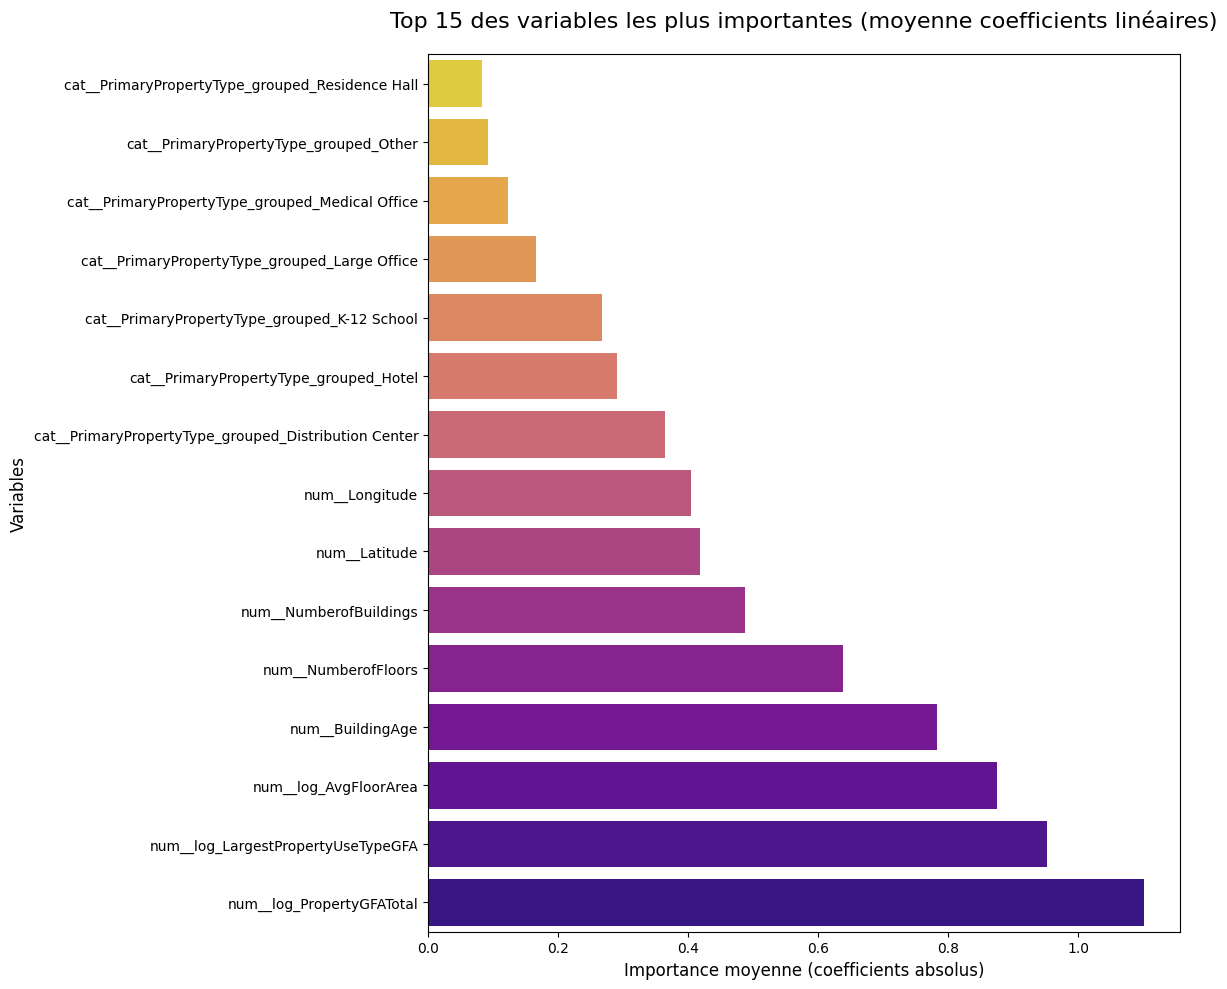


Top 15 des variables les plus importantes :
                                             Feature  Linear_Coefficient_Importance
                           num__log_PropertyGFATotal                       1.101707
                  num__log_LargestPropertyUseTypeGFA                       0.952334
                               num__log_AvgFloorArea                       0.874561
                                    num__BuildingAge                       0.782820
                                 num__NumberofFloors                       0.638376
                              num__NumberofBuildings                       0.488279
                                       num__Latitude                       0.417683
                                      num__Longitude                       0.403807
cat__PrimaryPropertyType_grouped_Distribution Center                       0.363938
              cat__PrimaryPropertyType_grouped_Hotel                       0.290406
        cat__PrimaryPropertyTyp

In [17]:
print("1. ANALYSE DES COEFFICIENTS - MODÈLES LINÉAIRES DU STACKING")
print("-" * 60)
#on analyse train pour le global et test pour le local
# Récupérer le préprocesseur
preproc_stack = stacking_refined.named_steps['prep']
feature_names = preproc_stack.get_feature_names_out()

# Transformer les données
X_train_transformed = preproc_stack.transform(X_train)
X_train_transformed_df = pd.DataFrame(
    X_train_transformed,
    columns=feature_names,
    index=X_train.index
)

# Analyser chaque composant linéaire
models_analysis = {}

for name, model in [('Ridge', best_fine_tuned_models['ridge']),
                    ('Lasso', best_fine_tuned_models['lasso']),
                    ('ElasticNet', best_fine_tuned_models['elasticnet'])]:

    model.fit(X_train_transformed, y_train)
    coefs = model.coef_

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs,
        'abs_coefficient': np.abs(coefs)
    }).sort_values('abs_coefficient', ascending=False)

    models_analysis[name] = importance_df

   
# Importance combinée : moyenne des coefficients absolus
print("\n2. IMPORTANCE MOYENNE - MODÈLES LINÉAIRES")
print("-" * 40)

combined_importance = pd.DataFrame({'Feature': feature_names})
for name in ['Ridge', 'Lasso', 'ElasticNet']:
    combined_importance[f'{name}_abs'] = models_analysis[name]['abs_coefficient'].values

combined_importance['Linear_Coefficient_Importance'] = combined_importance[
    ['Ridge_abs', 'Lasso_abs', 'ElasticNet_abs']
].mean(axis=1)

# Tri décroissant
combined_importance = combined_importance.sort_values(
    'Linear_Coefficient_Importance', ascending=False
)

# Top 15 pour visualisation
top_15_features = combined_importance.head(15)

# Visualisation seaborn
plt.figure(figsize=(12, 10))
sns.barplot(
    data=top_15_features,
    x='Linear_Coefficient_Importance',
    y='Feature',
    palette='plasma',
    orient='h'
)
plt.title('Top 15 des variables les plus importantes (moyenne coefficients linéaires)', fontsize=16, pad=20)
plt.xlabel('Importance moyenne (coefficients absolus)', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

# Affichage des valeurs numériques
print("\nTop 15 des variables les plus importantes :")
print(top_15_features[['Feature', 'Linear_Coefficient_Importance']].to_string(index=False))


Les variables les plus influentes dans la prédiction des émissions de CO₂ sont majoritairement liées à la taille du bâtiment (log_PropertyGFA, log_LargestPropertyUseTypeGFA)  ainsi qu'à ses caractéristiques structurelles (âge, nombre d’étages, nombre de bâtiments).  
Certaines variables catégorielles, notamment le type principal d’usage du bâtiment, apparaissent également comme significatives, en particulier les bâtiments de type Supermarket, Hotel ou School.  
L’estimation de l’importance des variables est basée sur la moyenne des coefficients absolus issus des modèles linéaires Ridge, Lasso et ElasticNet, ce qui renforce la robustesse de l’interprétation


COMPARAISON AVEC LES MÉTHODES NATIVES

 RIDGE
---------------------------------------------


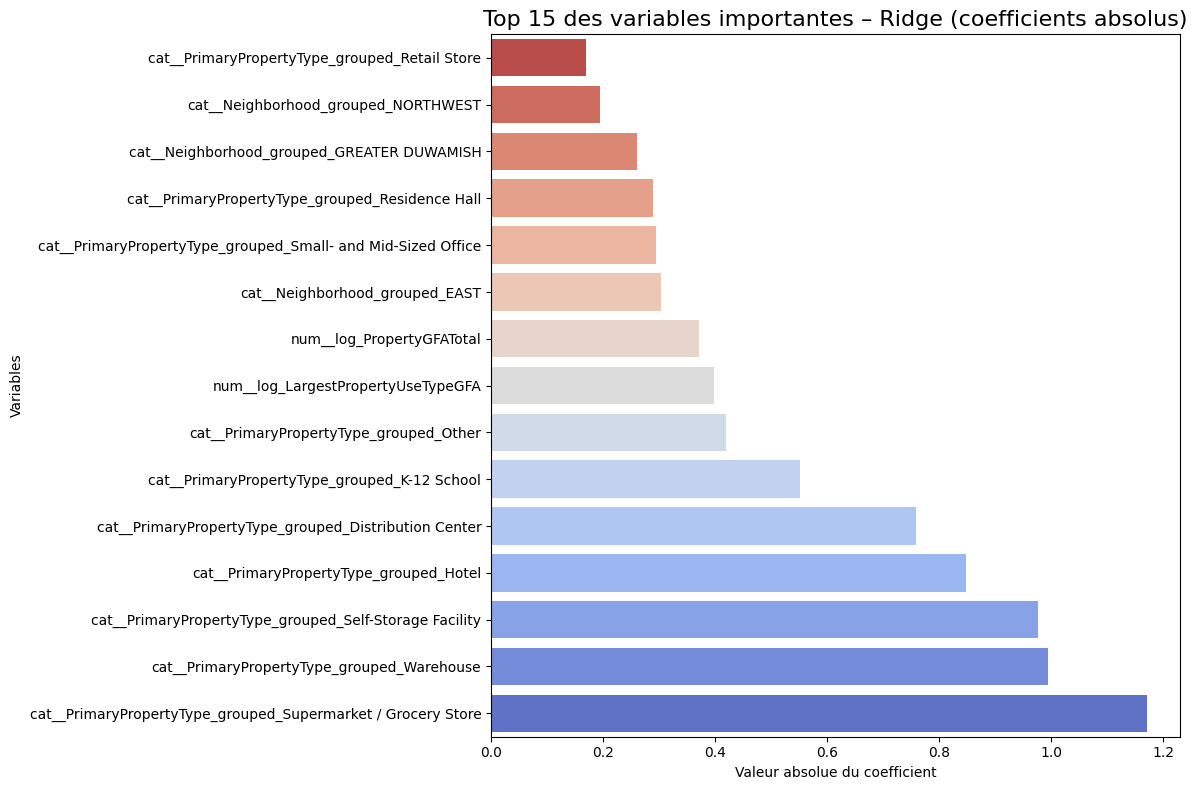

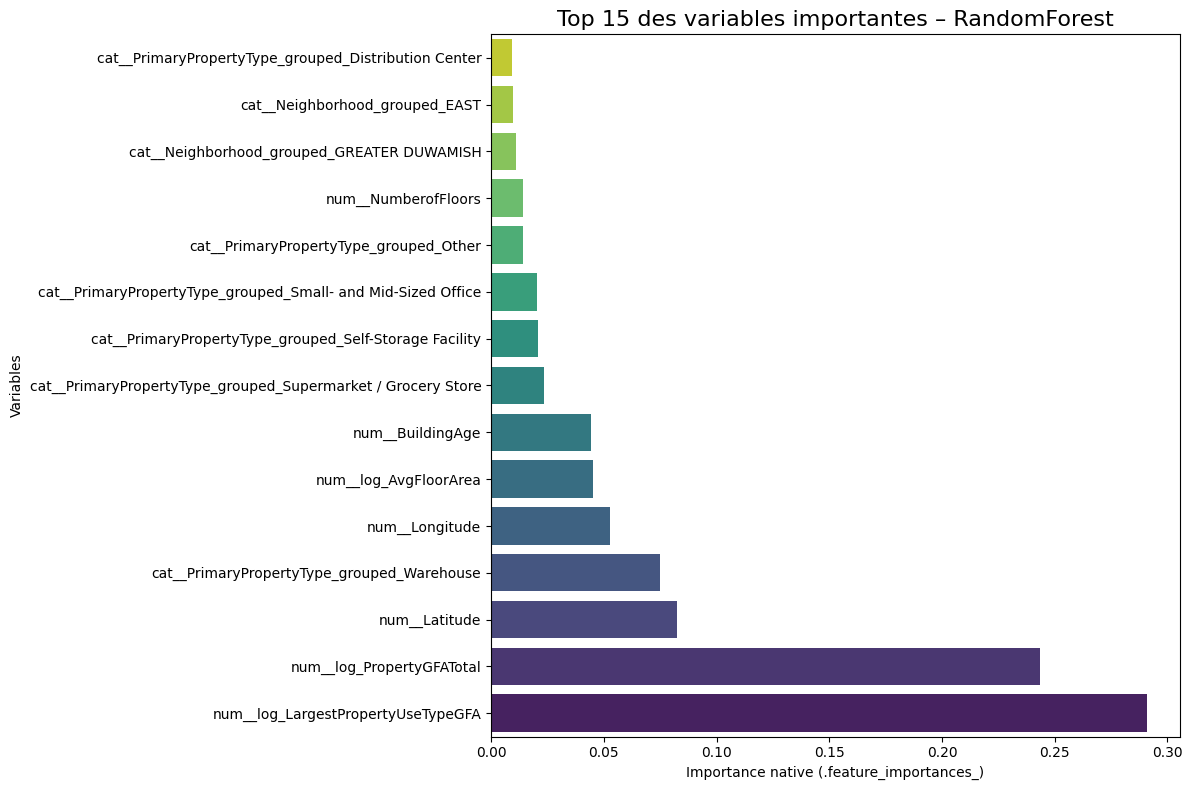

In [18]:
# Comparer avec les méthodes natives
print("COMPARAISON AVEC LES MÉTHODES NATIVES")
print("=" * 40)

# 1. Ridge - Coefficients
print("\n RIDGE")
print("-" * 45)

# Récupérer le modèle Ridge optimisé
ridge_model = best_fine_tuned_models['ridge']

# L'entraîner sur les données transformées pour avoir les coefficients
X_train_transformed = preproc.fit_transform(X_train)
ridge_model.fit(X_train_transformed, y_train)

# Récupérer les noms des features après transformation
feature_names = preproc.get_feature_names_out()

# Créer le DataFrame d'importance Ridge
ridge_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': ridge_model.coef_,
    'abs_coefficient': np.abs(ridge_model.coef_)
}).sort_values('abs_coefficient', ascending=False)


# Créer un RandomForest avec les mêmes paramètres optimisés

rf_model = RandomForestRegressor(
    n_estimators=300, 
    max_depth=10, 
    random_state=42,
    n_jobs=-1
)

# L'entraînement
rf_model.fit(X_train_transformed, y_train)

# Récupérer l'importance native
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

#  VISUALISATION SEABORN – Ridge 
plt.figure(figsize=(12, 8))
sns.barplot(
    data=ridge_importance.head(15),
    x='abs_coefficient',
    y='feature',
    palette='coolwarm',
    orient='h'
)
plt.title('Top 15 des variables importantes – Ridge (coefficients absolus)', fontsize=16)
plt.xlabel('Valeur absolue du coefficient')
plt.ylabel('Variables')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

# VISUALISATION SEABORN – RandomForest
plt.figure(figsize=(12, 8))
sns.barplot(
    data=rf_importance.head(15),
    x='importance',
    y='feature',
    palette='viridis',
    orient='h'
)
plt.title('Top 15 des variables importantes – RandomForest', fontsize=16)
plt.xlabel('Importance native (.feature_importances_)')
plt.ylabel('Variables')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()



Comparaison des méthodes natives d’importance des caractéristiques

Nous comparons ici deux approches natives d’estimation de l’importance des variables dans les modèles supervisés :

- Les **modèles linéaires** mettent souvent en avant des **variables numériques transformées** (e.g. `log_PropertyGFATotal`, `BuildingAge`, etc.).
- Les **modèles d’arbres** peuvent faire ressortir des interactions ou des catégories encodées qui n’étaient pas visibles dans les modèles linéaires.
- Une comparaison croisée permet de repérer les variables **consistantes** entre les méthodes (bonnes candidates pour un feature engineering plus poussé).

Ces deux méthodes seront encore enrichies par une interprétation plus fine avec **SHAP**, qui offre à la fois une vue globale et locale des impacts de chaque variable.


In [19]:
# Dictionnaire pour stocker les index des bâtiments à analyser
batiments_a_analyser = {}

# --- Sélection par Type de Bâtiment ---
colonne_type = 'PrimaryPropertyType_grouped' 
types_a_chercher = ['Warehouse', 'Hotel', 'Small- and Mid-Sized Office']
for type_batiment in types_a_chercher:
    selection = X_test[X_test[colonne_type] == type_batiment]
    if not selection.empty:
        batiments_a_analyser[type_batiment] = selection.index[0]

# --- Sélection par Taille ---
colonne_surface = 'log_PropertyGFATotal' # On utilise la version log que le modèle voit
batiments_a_analyser['Le plus grand'] = X_test[colonne_surface].idxmax()
batiments_a_analyser['Le plus petit'] = X_test[colonne_surface].idxmin()

print("Bâtiments sélectionnés pour l'analyse locale :")
print(batiments_a_analyser)

Bâtiments sélectionnés pour l'analyse locale :
{'Warehouse': np.int64(194), 'Hotel': np.int64(9), 'Small- and Mid-Sized Office': np.int64(300), 'Le plus grand': np.int64(11), 'Le plus petit': np.int64(665)}


Analyse de l'importance "locale" - zoom sur les bâtiments en particulier


Préparation des données de test pour l'analyse locale...
Calcul des valeurs SHAP pour les bâtiments sélectionnés...
-> Données prêtes pour l'analyse locale.

ANALYSE LOCALE - SHAP POUR BÂTIMENTS SPÉCIFIQUES

--- Analyse pour le cas : 'Warehouse' (Index du bâtiment : 194) ---
Caractéristiques principales :
  - Surface totale : 80361 sqft
  - Âge : 29 ans
  - Type : Warehouse
Top 10 features locales (SHAP):
   1. cat__PrimaryPropertyType_grouped_Warehou ↘ -1.1754
   2. num__log_LargestPropertyUseTypeGFA       ↗ +0.0901
   3. num__Latitude                            ↘ -0.0611
   4. num__BuildingAge                         ↘ -0.0360
   5. num__log_PropertyGFATotal                ↘ -0.0337
   6. cat__PrimaryPropertyType_grouped_Small-  ↗ +0.0310
   7. num__log_AvgFloorArea                    ↘ -0.0266
   8. cat__PrimaryPropertyType_grouped_Other   ↘ -0.0236
   9. cat__PrimaryPropertyType_grouped_Hotel   ↘ -0.0181
  10. cat__PrimaryPropertyType_grouped_Self-St ↗ +0.0152

Graphique Waterfall

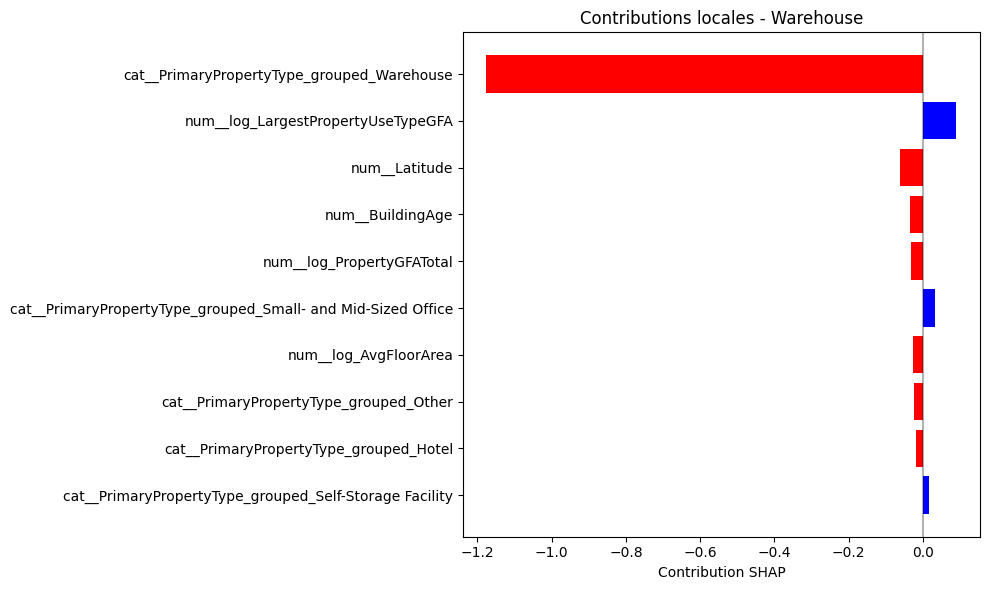

------------------------------------------------------------

--- Analyse pour le cas : 'Hotel' (Index du bâtiment : 9) ---
Caractéristiques principales :
  - Surface totale : 65010 sqft
  - Âge : 88 ans
  - Type : Hotel
Top 10 features locales (SHAP):
   1. num__log_LargestPropertyUseTypeGFA       ↗ +0.3114
   2. cat__PrimaryPropertyType_grouped_Hotel   ↗ +0.2429
   3. cat__PrimaryPropertyType_grouped_Warehou ↗ +0.2101
   4. cat__PrimaryPropertyType_grouped_Small-  ↗ +0.1170
   5. num__NumberofFloors                      ↗ +0.0879
   6. num__BuildingAge                         ↗ +0.0651
   7. cat__PrimaryPropertyType_grouped_Self-St ↗ +0.0476
   8. num__log_PropertyGFATotal                ↗ +0.0254
   9. cat__PrimaryPropertyType_grouped_Other   ↘ -0.0248
  10. num__log_AvgFloorArea                    ↗ +0.0236

Graphique Waterfall pour 'Hotel':


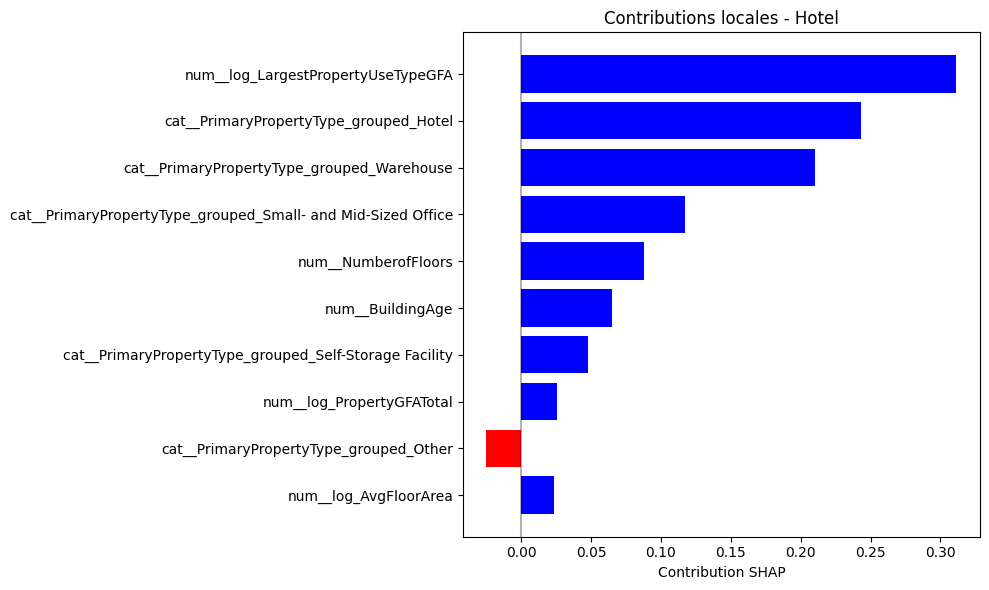

------------------------------------------------------------

--- Analyse pour le cas : 'Small- and Mid-Sized Office' (Index du bâtiment : 300) ---
Caractéristiques principales :
  - Surface totale : 70297 sqft
  - Âge : 36 ans
  - Type : Small- and Mid-Sized Office
Top 10 features locales (SHAP):
   1. cat__PrimaryPropertyType_grouped_Small-  ↘ -0.4610
   2. cat__PrimaryPropertyType_grouped_Warehou ↗ +0.1564
   3. num__log_LargestPropertyUseTypeGFA       ↗ +0.0955
   4. num__log_PropertyGFATotal                ↘ -0.0699
   5. cat__PrimaryPropertyType_grouped_Other   ↘ -0.0367
   6. num__Latitude                            ↘ -0.0303
   7. num__BuildingAge                         ↘ -0.0275
   8. cat__Neighborhood_grouped_MAGNOLIA / QUE ↗ +0.0248
   9. num__log_AvgFloorArea                    ↗ +0.0231
  10. cat__PrimaryPropertyType_grouped_Hotel   ↘ -0.0210

Graphique Waterfall pour 'Small- and Mid-Sized Office':


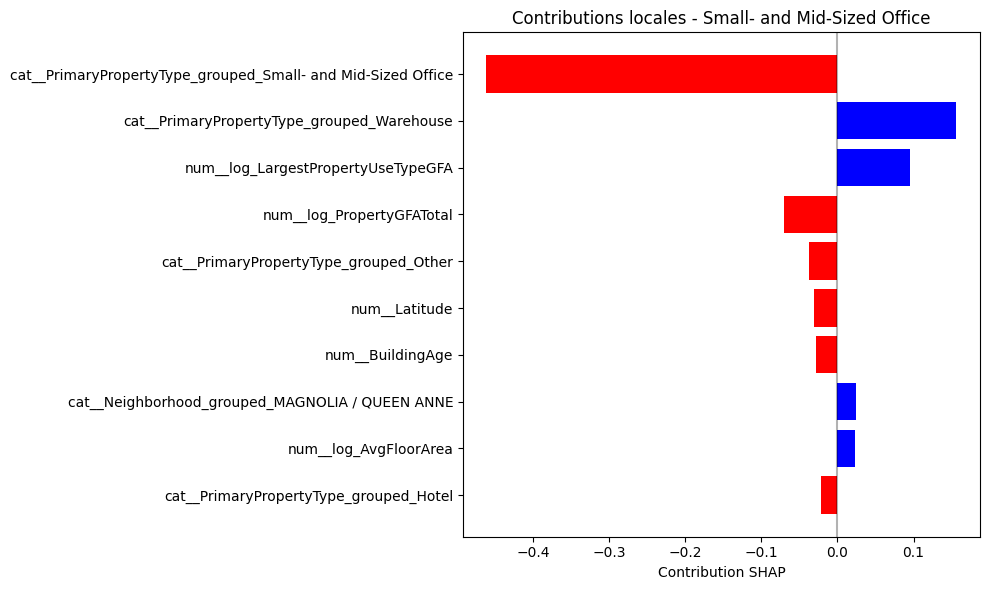

------------------------------------------------------------

--- Analyse pour le cas : 'Le plus grand' (Index du bâtiment : 11) ---
Caractéristiques principales :
  - Surface totale : 540361 sqft
  - Âge : 100 ans
  - Type : Other
Top 10 features locales (SHAP):
   1. num__log_PropertyGFATotal                ↗ +1.3961
   2. num__log_LargestPropertyUseTypeGFA       ↗ +1.3828
   3. cat__PrimaryPropertyType_grouped_Other   ↗ +0.1155
   4. num__NumberofFloors                      ↗ +0.1034
   5. cat__PrimaryPropertyType_grouped_Warehou ↗ +0.0857
   6. num__log_AvgFloorArea                    ↘ -0.0406
   7. cat__PrimaryPropertyType_grouped_Small-  ↗ +0.0282
   8. cat__PrimaryPropertyType_grouped_Large O ↗ +0.0275
   9. cat__Neighborhood_grouped_GREATER DUWAMI ↗ +0.0203
  10. cat__PrimaryPropertyType_grouped_Self-St ↗ +0.0154

Graphique Waterfall pour 'Le plus grand':


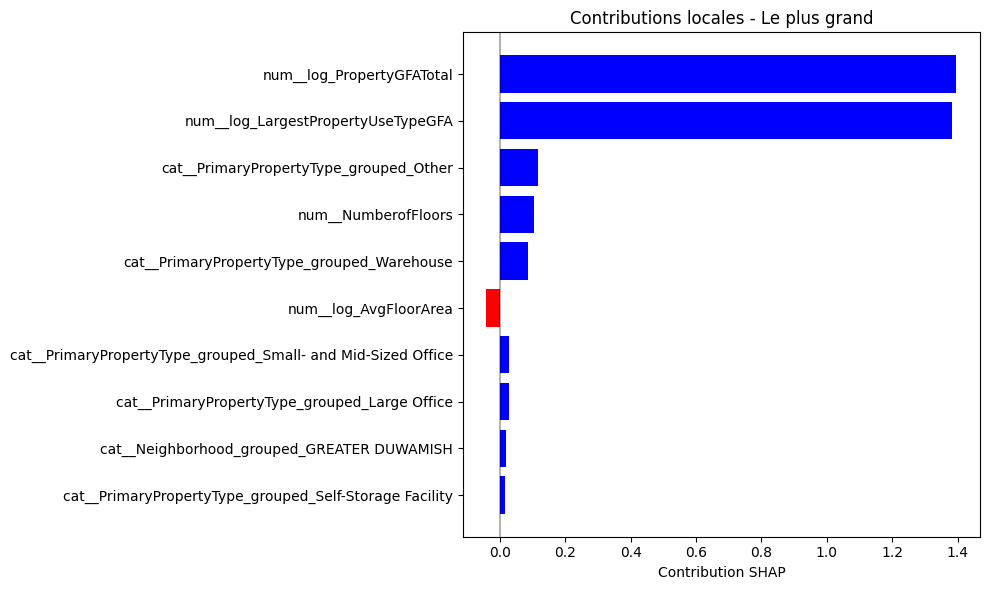

------------------------------------------------------------

--- Analyse pour le cas : 'Le plus petit' (Index du bâtiment : 665) ---
Caractéristiques principales :
  - Surface totale : 11286 sqft
  - Âge : 67 ans
  - Type : Other
Top 10 features locales (SHAP):
   1. num__log_LargestPropertyUseTypeGFA       ↘ -0.6173
   2. num__log_PropertyGFATotal                ↘ -0.5576
   3. num__Latitude                            ↗ +0.1861
   4. cat__PrimaryPropertyType_grouped_Warehou ↗ +0.1285
   5. cat__PrimaryPropertyType_grouped_Other   ↗ +0.0725
   6. cat__PrimaryPropertyType_grouped_Superma ↘ -0.0317
   7. cat__PrimaryPropertyType_grouped_Small-  ↗ +0.0290
   8. cat__Neighborhood_grouped_EAST           ↘ -0.0273
   9. num__Longitude                           ↘ -0.0246
  10. cat__PrimaryPropertyType_grouped_Self-St ↗ +0.0178

Graphique Waterfall pour 'Le plus petit':


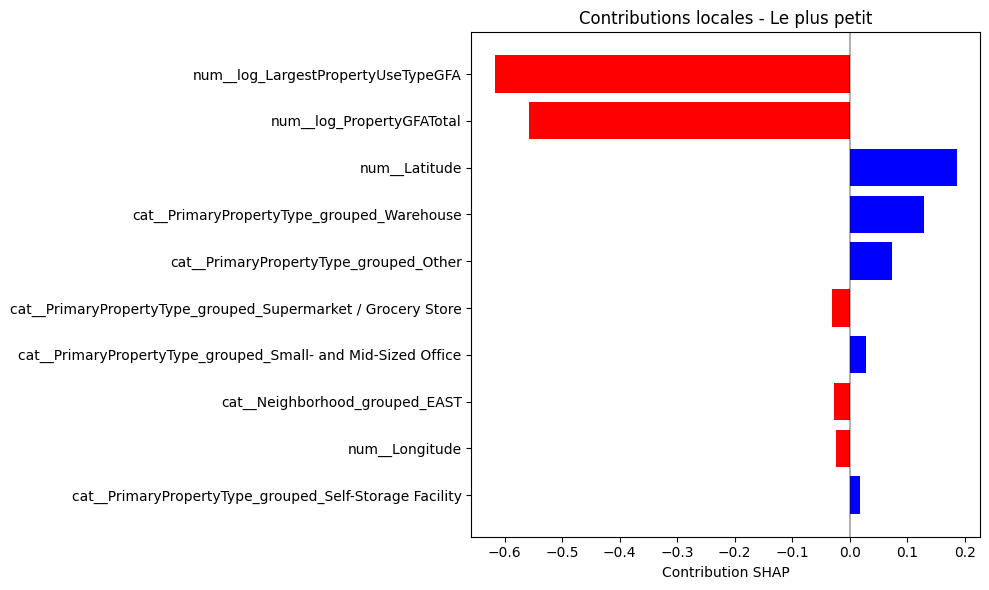

------------------------------------------------------------

ANALYSE LOCALE TERMINÉE


In [20]:
# PRÉPARATION POUR L'ANALYSE LOCALE SUR LE JEU DE TEST
print("\nPréparation des données de test pour l'analyse locale...")

# 1. Transformer les données de test avec le même préprocesseur
X_test_transformed = preproc.transform(X_test)

# 2. Créer le DataFrame transformé pour le jeu de test
X_test_transformed_df = pd.DataFrame(
    X_test_transformed,
    columns=feature_names,
    index=X_test.index
)

# On doit créer un explainer SHAP pour notre RandomForest

explainer = shap.TreeExplainer(rf_model)

# Calculer les valeurs SHAP pour les bâtiments sélectionnés uniquement

selected_indices = list(batiments_a_analyser.values())
X_selected = X_test_transformed_df.loc[selected_indices]

print("Calcul des valeurs SHAP pour les bâtiments sélectionnés...")
shap_values_selected = explainer.shap_values(X_selected)

print("-> Données prêtes pour l'analyse locale.")

# ANALYSE LOCALE POUR CHAQUE BÂTIMENT
print("\n" + "="*60)
print("ANALYSE LOCALE - SHAP POUR BÂTIMENTS SPÉCIFIQUES")
print("="*60)

for i, (nom_cas, idx) in enumerate(batiments_a_analyser.items()):
    
    print(f"\n--- Analyse pour le cas : '{nom_cas}' (Index du bâtiment : {idx}) ---")
    
    # Informations sur le bâtiment
    building_data = X_test.loc[idx]
    print(f"Caractéristiques principales :")
    print(f"  - Surface totale : {np.exp(building_data['log_PropertyGFATotal']):.0f} sqft")
    print(f"  - Âge : {building_data['BuildingAge']:.0f} ans")
    print(f"  - Type : {building_data['PrimaryPropertyType_grouped']}")
    
    # Top 10 features locales les plus importantes
    shap_values_building = shap_values_selected[i]
    local_importance = pd.DataFrame({
        'feature': feature_names,
        'shap_value': shap_values_building,
        'abs_shap': np.abs(shap_values_building)
    }).sort_values('abs_shap', ascending=False)
    
    print(f"Top 10 features locales (SHAP):")
    for j, (_, row) in enumerate(local_importance.head(10).iterrows()):
        direction = "↗" if row['shap_value'] > 0 else "↘"
        print(f"  {j+1:2}. {row['feature'][:40]:<40} {direction} {row['shap_value']:+.4f}")
    
    # Waterfall plot
    print(f"\nGraphique Waterfall pour '{nom_cas}':")
    try:
        shap.waterfall_plot(
            explainer.expected_value, 
            shap_values_building, 
            X_selected.iloc[i],
            max_display=12,
            show=True
        )
    except:
        # Version alternative si waterfall ne fonctionne pas
        plt.figure(figsize=(10, 6))
        top_features = local_importance.head(10)
        colors = ['red' if x < 0 else 'blue' for x in top_features['shap_value']]
        plt.barh(range(len(top_features)), top_features['shap_value'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Contribution SHAP')
        plt.title(f'Contributions locales - {nom_cas}')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    print("-" * 60)

print("\nANALYSE LOCALE TERMINÉE")

1. Analyse sur les entrepôts  
Le type de bâtiment est la variable la plus influente, La surface a un effet positif , L'âge et la localisation ont un impact négatif  
Ces résultats confirment que le modèle s'appuie principalement sur les caractéristiques les plus pertinentes (Warehouse, Surface) pour faire sa prédiction


2. Analyse sur les hôtels  
Le modèle se base principalement sur les facteurs les plus logiques pour prédire les émissions de carbone d'un hôtel, à savoir sa surface et son type de bâtiment.   Ces caractéristiques sont les plus grandes causes d'émissions, et les autres caractéristiques comme le nombre d'étages ou l'âge du bâtiment ne font que confirmer cette prédiction. Le groupe Other a une influence légèrement négative ce qui signifie que le modèle a appris qu'un hôtel avait plus d'émissions qu'un bâtiment lambda

3. Analyse sur les petits et moyens bureaux  
L'impact négatif de la caractéristique small et mid-sized office montre que la prédiction est fortement revue à la baisse lorsque ce sont ce type de bâtiments, par contre à la hausse pour la surface (comme pour les autres)  et également les entrepôts qui ont des emissions plus élevées qu'un petit bureau

4. Analyse sur les plus grands bâtiments  
Le modèle indique que la surface totale et la surface de la plus grande utilisation sont les deux contributeurs les plus importants. La taille immense de ce bâtiment explique la quasi-totalité de sa prédiction élevée d'émissions. C'est donc limpide ici c'est bien la taille qui compte

5. Analyse sur les plus petits bâtiments non résidentiels  
le modèle prédit naturellement que ses émissions de carbone seront faibles, et il se base principalement sur sa petite taille pour faire cette prédiction.  
 D'autres facteurs, comme son emplacement ou son usage, augmentent légèrement la prédiction, mais ne suffisent pas à compenser l'effet massif de sa taille.

11. Analyse de l'impact de la variable EnergyStarScore

In [21]:
 #On part du dataFrame qui contient toutes les features améliorées

df_subset = df_engineered.dropna(subset=['ENERGYSTARScore']).copy()
print(f"Taille du sous-ensemble avec EnergyStarScore : {len(df_subset)} lignes")

# On définit la cible 
target = 'log_TotalGHGEmissions'
y_subset = df_subset[target]


# Liste des features de base
base_features = [
    'log_PropertyGFATotal', 'log_LargestPropertyUseTypeGFA', 'log_AvgFloorArea',
    'BuildingAge', 'NumberofFloors', 'NumberofBuildings', 'Latitude', 'Longitude'
]
categorical_features = ['PrimaryPropertyType_grouped', 'Neighborhood_grouped']

#Configuration des features
features_sans_score = base_features + categorical_features
features_avec_score = base_features + ['ENERGYSTARScore'] + categorical_features

X_sans_score = df_subset[features_sans_score]
X_avec_score = df_subset[features_avec_score]

Taille du sous-ensemble avec EnergyStarScore : 669 lignes


In [22]:
# Préprocesseur pour le modèle SANS le score (il est identique à votre 'preprocessor' actuel)
preprocessor_sans_score = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), base_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Préprocesseur pour le modèle AVEC le score
preprocessor_avec_score = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), base_features + ['ENERGYSTARScore']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# On divise les deux jeux de données de la même manière pour une comparaison juste
X_train_sans, X_test_sans, y_train, y_test = train_test_split(X_sans_score, y_subset, test_size=0.2, random_state=42)
X_train_avec, X_test_avec, _, _ = train_test_split(X_avec_score, y_subset, test_size=0.2, random_state=42)

In [24]:
#4. COMPARAISON VALIDE - LES DEUX MODÈLES SUR LE MÊME SOUS-ENSEMBLE
print("\n--- ENTRAÎNEMENT DES MODÈLES STACKING ---")

# Estimateurs de base (mêmes hyperparamètres optimaux)
stack_estimators = [
    ('ridge', Ridge(alpha=1.0)),
    ('lasso', Lasso(alpha=0.01, max_iter=2000)),
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.9, max_iter=2000))
]

# Modèle SANS ENERGYSTARScore
print("Entraînement Stacking SANS ENERGYSTARScore...")
stacking_sans = Pipeline([
    ('prep', preprocessor_sans_score),
    ('model', StackingRegressor(
        estimators=stack_estimators,
        final_estimator=LinearRegression(),
        cv=5,
        n_jobs=-1
    ))
])

stacking_sans.fit(X_train_sans, y_train)
score_sans = stacking_sans.score(X_test_sans, y_test)

# Modèle AVEC ENERGYSTARScore
print("Entraînement Stacking AVEC ENERGYSTARScore...")
stacking_avec = Pipeline([
    ('prep', preprocessor_avec_score),
    ('model', StackingRegressor(
        estimators=stack_estimators,
        final_estimator=LinearRegression(),
        cv=5,
        n_jobs=-1
    ))
])

stacking_avec.fit(X_train_avec, y_train)
score_avec = stacking_avec.score(X_test_avec, y_test)

# 5. RÉSULTATS ET ANALYSE
print("\n" + "="*60)
print("RÉSULTATS DE LA COMPARAISON")
print("="*60)

print(f"R² Stacking SANS ENERGYSTARScore : {score_sans:.4f}")
print(f"R² Stacking AVEC ENERGYSTARScore : {score_avec:.4f}")

# Calcul de l'amélioration
amelioration = score_avec - score_sans
pourcentage_amelioration = (amelioration / abs(score_sans)) * 100

print(f"\nAmélioration apportée par ENERGYSTARScore :")
print(f"Gain en R² : {amelioration:+.4f}")
print(f"Amélioration relative : {pourcentage_amelioration:+.2f}%")

# Interprétation
if amelioration > 0.01:
    print("✓ ENERGYSTARScore apporte une amélioration significative")
elif amelioration > 0:
    print("→ ENERGYSTARScore apporte une amélioration marginale")
elif amelioration > -0.01:
    print("→ ENERGYSTARScore n'apporte pas d'amélioration notable")
else:
    print("✗ ENERGYSTARScore dégrade la performance")

# 6. ANALYSE COMPLÉMENTAIRE - Cross-validation
print("\n--- VALIDATION CROISÉE POUR CONFIRMATION ---")

from sklearn.model_selection import cross_val_score

# CV pour les deux modèles
cv_scores_sans = cross_val_score(stacking_sans, X_train_sans, y_train, cv=5, scoring='r2')
cv_scores_avec = cross_val_score(stacking_avec, X_train_avec, y_train, cv=5, scoring='r2')

print(f"CV R² SANS ENERGYSTARScore : {cv_scores_sans.mean():.4f} ± {cv_scores_sans.std():.4f}")
print(f"CV R² AVEC ENERGYSTARScore : {cv_scores_avec.mean():.4f} ± {cv_scores_avec.std():.4f}")

# 7. PRÉDICTIONS POUR QUELQUES EXEMPLES
print("\n--- EXEMPLES DE PRÉDICTIONS ---")
sample_indices = X_test_avec.index[:3]

for i, idx in enumerate(sample_indices):
    building_data = df_subset.loc[idx]
    
    pred_sans = stacking_sans.predict(X_test_sans.loc[[idx]])[0]
    pred_avec = stacking_avec.predict(X_test_avec.loc[[idx]])[0]
    actual = y_test.loc[idx]
    energy_score = building_data['ENERGYSTARScore']
    
    print(f"\nBâtiment {i+1} (ENERGYSTARScore: {energy_score:.0f}):")
    print(f"  Réel : {actual:.3f}")
    print(f"  Pred SANS score : {pred_sans:.3f}")
    print(f"  Pred AVEC score : {pred_avec:.3f}")
    print(f"  Amélioration : {abs(pred_avec - actual) - abs(pred_sans - actual):+.3f}")




--- ENTRAÎNEMENT DES MODÈLES STACKING ---
Entraînement Stacking SANS ENERGYSTARScore...
Entraînement Stacking AVEC ENERGYSTARScore...

RÉSULTATS DE LA COMPARAISON
R² Stacking SANS ENERGYSTARScore : 0.4250
R² Stacking AVEC ENERGYSTARScore : 0.4372

Amélioration apportée par ENERGYSTARScore :
Gain en R² : +0.0122
Amélioration relative : +2.87%
✓ ENERGYSTARScore apporte une amélioration significative

--- VALIDATION CROISÉE POUR CONFIRMATION ---
CV R² SANS ENERGYSTARScore : 0.4936 ± 0.0472
CV R² AVEC ENERGYSTARScore : 0.5510 ± 0.0487

--- EXEMPLES DE PRÉDICTIONS ---

Bâtiment 1 (ENERGYSTARScore: 60):
  Réel : 3.520
  Pred SANS score : 1.958
  Pred AVEC score : 1.851
  Amélioration : +0.107

Bâtiment 2 (ENERGYSTARScore: 89):
  Réel : 3.198
  Pred SANS score : 3.860
  Pred AVEC score : 3.526
  Amélioration : -0.335

Bâtiment 3 (ENERGYSTARScore: 44):
  Réel : 4.832
  Pred SANS score : 2.439
  Pred AVEC score : 2.562
  Amélioration : -0.123


L' ENERGYSTARScore est donc une variable utile.  
Elle améliore la performance du modèle, de manière modérée mais régulière, aussi bien en test simple qu’en validation croisée.  
L'amélioration est modeste (un peu plus de 2.87%), mais elle est confirmée par la validation croisée, ce qui lui donne de la crédibilité.  
Elle reste **stable** sur les observations testées,  
Elle peut potentiellement être **exploitée davantage** via une transformation non-linéaire (log par exemple) ou en transformant par exemple la feature en la multipliant par la surface du bâtiment.